# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: FusionBites - A Multilabel Image Classification

This notebook is part of a project to build a food classification algorithm for a hypothetical new type of food item, which we will call FusionBite. FusionBite is an innovative culinary creation that is a combination of sushi and a sandwich.

The ultimate goal of this project is to develop a machine learning model that can accept an image as input and correctly identify whether the image contains a sandwich, sushi, or the combination of them.

### The Road Ahead

The project is organized into several steps. Use the links below to navigate through the notebook.

- [1. Import and Understanding Datasets](#section1)
- [2. Data Preprocessing and Augmentation](#section2)
- [3. Model Training and Analysis](#section3)
- [4. Model Inference](#section4)
- [5. Conclusion and Future Work](#section5)

<a id='section1'></a>
## Section 1: Import and Understanding Datasets

### Import Sushi and Sandwich Dataset

In the code cell below, we import a dataset of sushi and sandwich dataset. We will download the dataset from [here](http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip), store into into `data/` folder and split the dataset into `train` and `test` set.

In [1]:
from src.utils.data import get_data_and_split

# Create sub-folder in results
get_data_and_split(
    link="http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip", # provide dataset link
    test_size=150, # provide test image number, in this case we set 150 images as test images on each class
    seed=42) # random seed for reproducible

[INFO] DOWNLOADING DATASET ...


sushi_or_sandwich_photos.zip: 100%|████████████████████████████████████████████| 90.1M/90.1M [1:10:01<00:00, 22.5kiB/s]


[INFO] EXTRACTING DATASET ...
[INFO] SPLITTING TRAIN TEST DATASET ...


In [2]:
import os

# Checking dataset numbers
for dirpath, dirnames, filenames in os.walk("data/"):
    if "__MACOSX" not in dirpath:
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 2 images in 'data/'.
There are 2 directories and 0 images in 'data/test'.
There are 0 directories and 75 images in 'data/test\sandwich'.
There are 0 directories and 75 images in 'data/test\sushi'.
There are 2 directories and 0 images in 'data/train'.
There are 0 directories and 327 images in 'data/train\sandwich'.
There are 0 directories and 327 images in 'data/train\sushi'.


Before we begin building our model, let's take a closer look at our dataset.
Each image is either a sushi or a sandwich. We also consider the case where an image may contain a fusion of both, sushi and sandwich, which brings us to the multi-label classification task.

Here are a few things to consider about this dataset:

- **Balance**: The dataset is balanced, meaning there's an equal number of sushi and sandwich images. This is ideal for training a machine learning model as it provides an equal opportunity to learn the features of both classes.

- **Labels**: Each image in the dataset is labeled as either 'sushi' or 'sandwich', or both. This labeling allows us to use supervised learning methods to train our model. 

- **Quality and Variety**: The images are of high quality and show a wide variety of sushi and sandwiches, in different shapes, sizes, and arrangements. This variety is beneficial as it allows our model to learn from a diverse set of examples, improving its ability to generalize to unseen data.

- **Size**: The size of the dataset is adequate for our task. With 804 images, we have a fair amount of data to train our model without risking overfitting. However, it's not so large that we would need excessive computational resources to process it.

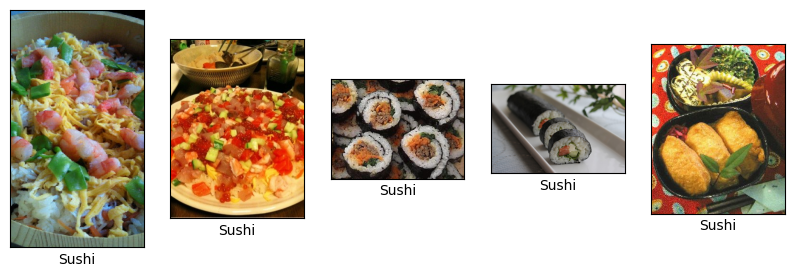

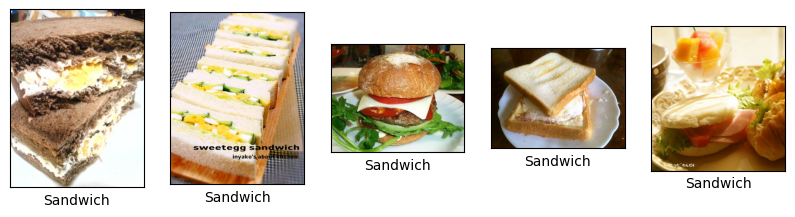

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# data path
sushi_dir = 'data/train/sushi'
sandwich_dir = 'data/train/sandwich'

# Function to display a grid of images
def display_images(image_dir, title, num_images=5):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        img_path = os.path.join(image_dir, os.listdir(image_dir)[i])
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(title)
    plt.show()

# Display sushi images
display_images(sushi_dir, "Sushi")

# Display sandwich images
display_images(sandwich_dir, "Sandwich")

For the next part of our EDA, we will check the dimensions of our images. It's important to ensure that they all have the same dimensions because differing dimensions can create issues when training our machine learning model.

In [4]:
# Function to get image dimensions
def get_image_dims(image_dir):
    dims = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = mpimg.imread(img_path)
        dims.append(img.shape)
    return dims

# Get image dimensions
sushi_dims = get_image_dims(sushi_dir)
sandwich_dims = get_image_dims(sandwich_dir)

# Print some stats
print(f'Sushi - Min Dims: {min(sushi_dims)}, Max Dims: {max(sushi_dims)}')
print(f'Sandwich - Min Dims: {min(sandwich_dims)}, Max Dims: {max(sandwich_dims)}')

Sushi - Min Dims: (120, 160, 3), Max Dims: (1778, 1000, 3)
Sandwich - Min Dims: (92, 140, 3), Max Dims: (1778, 1000, 3)


The minimum dimensions of the sushi images are 120x160 pixels, and they can be as large as 1778x1000 pixels. Similarly, the minimum dimensions of the sandwich images are 92x140 pixels, and the maximum dimensions are 1778x1000 pixels. This indicates that the image sizes are not uniform across the dataset. Non-uniform image sizes can often lead to challenges in training our model, as most neural networks expect input of a consistent shape. We will need to resize our images to a consistent shape during the preprocessing stage. This may lead to some distortion or loss of information for images that are much larger or smaller than our chosen input size.

The depth of all images is 3, indicating that they are all color images with red, green, and blue (RGB) channels. This is important information for setting up the input to our model, as grayscale (single channel) and color images are handled differently.

We can also analyze other aspects of our images such as color distribution, aspect ratios etc. Here's a script for showing the distribution of color intensities in our dataset.

In [5]:
import numpy as np

def plot_color_histogram(image_paths, title, image_index):
    colors = ("r", "g", "b")
    path = image_paths[image_index-1]
    image = mpimg.imread(path)
    plt.figure(figsize=(8, 4))
    plt.title(f'Color Intensity Distribution in {title} Images')
    for i, color in enumerate(colors):
        histogram, bins = np.histogram(image[:,:,i].ravel(), bins=256, range=[0,256])
        plt.plot(bins[:-1], histogram, color=color)
        plt.xlim([0, 256])

sushi_image_paths = [os.path.join('data/train/sushi', i) for i in os.listdir('data/train/sushi')]
sandwich_image_paths = [os.path.join('data/train/sandwich', i) for i in os.listdir('data/train/sandwich')]

We will analyze the five three data from each class (image shown above), start from sushi

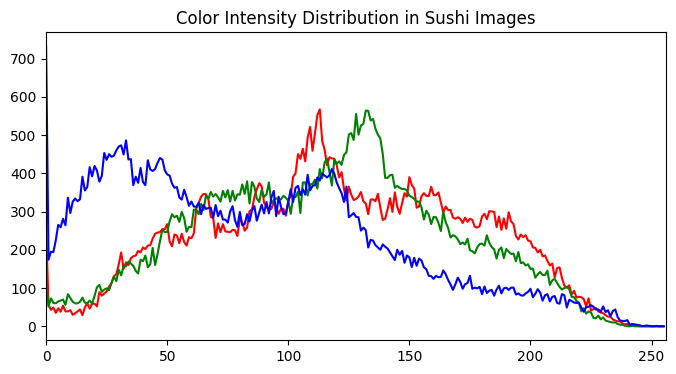

In [6]:
plot_color_histogram(sushi_image_paths, 'Sushi', 1)

The color intensity values range from 0 to 732, with the majority of values being between 100 and 500. The distribution appears to be approximately symmetrical, with a peak around 350-400. This could indicate that most of the sushi images in this set have a medium color intensity, with fewer images at the extremes of very light or very dark.

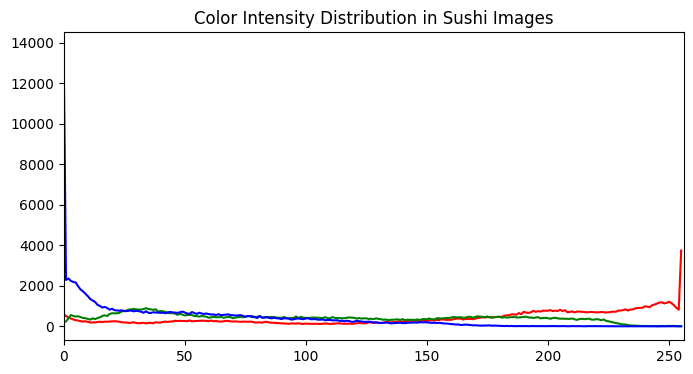

In [7]:
plot_color_histogram(sushi_image_paths, 'Sushi', 2)

Here, the color intensity values range from 0 to 13816, which is a significantly wider range than in the first dataset. The distribution appears to have a sharp peak around the low color intensity, suggesting that the images in this set are generally darker. After the peak, the distribution drops off and then seems to plateau, suggesting a steady frequency of medium-intensity values.

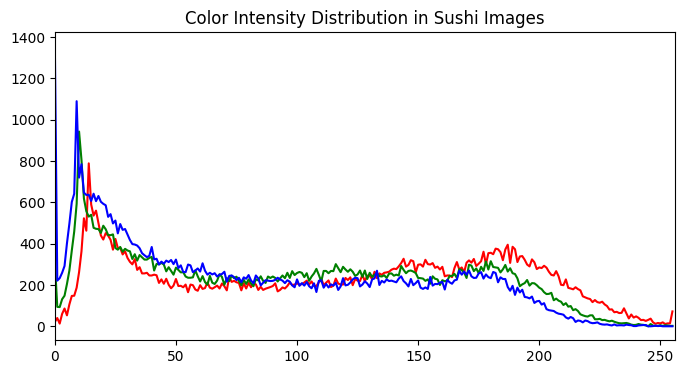

In [8]:
plot_color_histogram(sushi_image_paths, 'Sushi', 3)

In this case, the color intensity values range from 0 to 1356. The distribution is somewhat uneven, with multiple peaks and troughs. The highest peak is around the 300-350 range, suggesting a higher frequency of medium-dark images. There is another significant peak at the low end of the range, indicating a substantial number of very dark images.

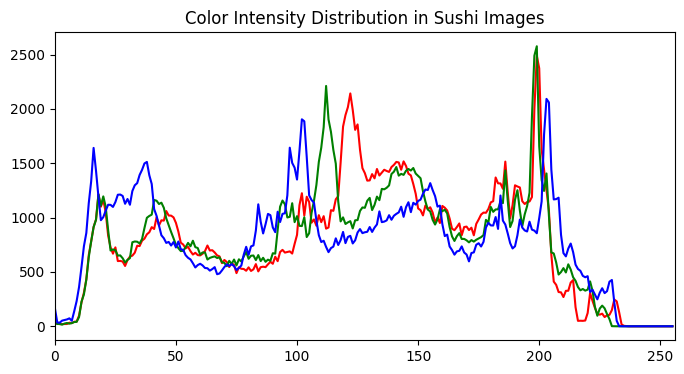

In [9]:
plot_color_histogram(sushi_image_paths, 'Sushi', 4)

In this case the counts gradually increase, peaking around mid-to-high level intensities (1334 and 1904 respectively), likely corresponding to the variety of colors found in sushi, from the darker seaweed and fish to the lighter rice, along with potential light reflections. The lower counts in the extremes of the histogram (0-10 and 218-255) indicate fewer very dark or bright pixels, suggesting the images lack significant areas of pitch black or near-white colors. The sharp drop to zero beyond index 218 suggests the images have no pixels at the highest intensities, indicating that the images are overall slightly darker and contain no purely white elements.

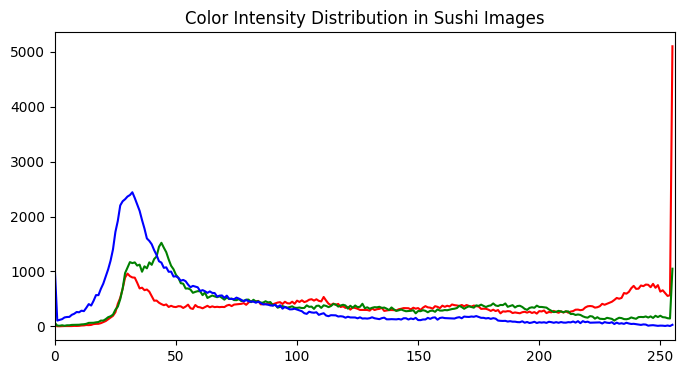

In [10]:
plot_color_histogram(sushi_image_paths, 'Sushi', 5)

In this case, the counts rise rather quickly and reach their highest around the mid-level intensities (around 2202 to 2442), suggesting a predominance of medium intensity pixels, typical in balanced images with diverse color range. Following this peak, counts drop off gradually until reaching a plateau (around 400 to 600 counts), indicating a smaller but consistent presence of darker pixels. The count drops significantly towards the extremes, especially in the darker range, reflecting fewer extremely dark or light elements. The presence of very low counts towards the highest intensity levels suggests a lack of overexposed or near-white elements in these images. This distribution could suggest detailed, well-lit images with balanced exposure and rich color variance.

In conclusion, each dataset represents a different distribution of color intensities, suggesting that the sets of sushi images may have different lighting conditions, color compositions, or image processing techniques. These differences could be due to factors like the type of sushi in the images, the location where the photos were taken, the camera settings, or post-processing of the images.

Now let's analyze sandwiches images

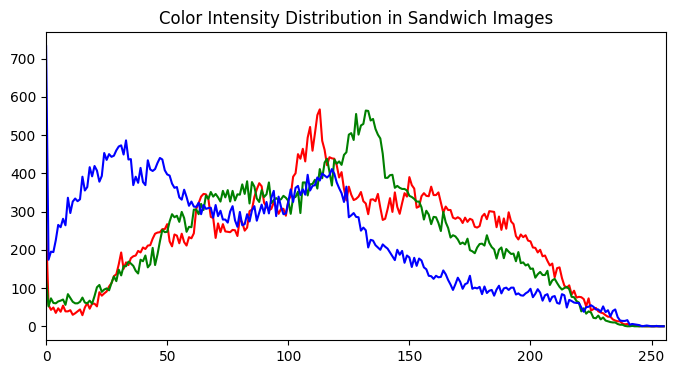

In [11]:
plot_color_histogram(sushi_image_paths, 'Sandwich', 1)

The histogram of pixel intensities for this sandwich image reflects a broad range of color and intensity values. The peak occurs at lower-to-mid intensities (around 732), suggesting the images are generally darker or have more mid-tone elements like brown bread or meat. The count remains relatively stable and high in the mid-range intensities (around 200-400), denoting well-balanced illumination and color composition in the images. As we move towards higher intensity levels, the count reduces but at a slower pace, demonstrating some bright elements (like fresh vegetables or cheese) are also present, but not as predominant. Towards the extreme ends, especially the highest intensity level, the counts drop significantly, implying fewer elements with extreme dark or light pixels. This can be indicative of good lighting conditions, avoiding overexposure or overly dark areas. The histogram reflects a typical balance of dark, mid-tone, and bright elements often seen in images of sandwiches.

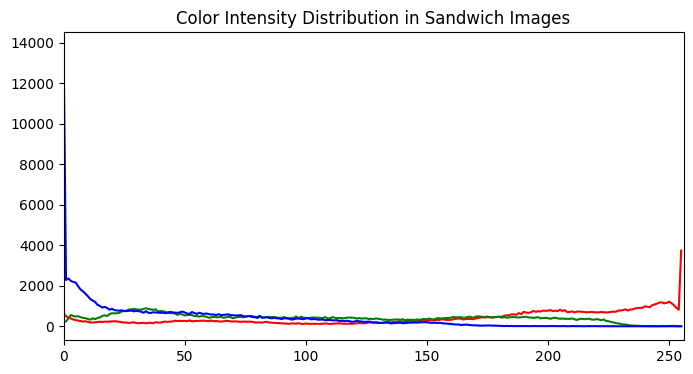

In [12]:
plot_color_histogram(sushi_image_paths, 'Sandwich', 2)

This histogram reflects a high count of very low-intensity pixels (at 13816), indicating a predominant presence of dark elements in the images, potentially a sign of underexposure or a high quantity of dark-colored elements. As we proceed towards the mid-intensity range, the counts drop significantly, suggesting less presence of mid-tone values. There are some peaks and valleys in the mid-range, indicating areas with different degrees of illumination or color. As we reach higher intensity levels, the counts progressively diminish, displaying a limited presence of bright elements. Towards the extreme end of the intensity range, the counts drop to zero, which can suggest an absence of overexposed elements. This could indicate a well-controlled lighting environment, despite a prominent presence of darker elements. However, this could also indicate a lack of contrast and detail in the brighter areas of the images. The overall shape of the histogram suggests the images could be substantially dark or comprise a significant number of darker elements.

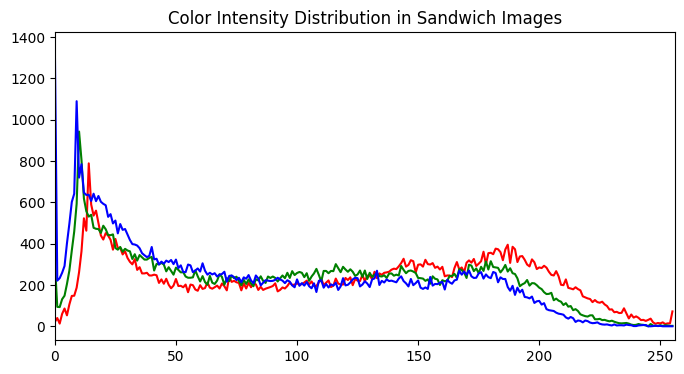

In [13]:
plot_color_histogram(sushi_image_paths, 'Sandwich', 3)

At the very beginning of the range (pixel intensity value 0), we see a relatively high count (1356) suggesting the presence of black or very dark pixels. Following that, the frequency decreases and fluctuates up to an intensity value of 642, indicating that there are varying amounts of dark and mid-toned pixels in the image.

The highest count of pixels in this image is at an intensity value of 1090, suggesting that this color intensity is the most frequent in the image, likely contributing significantly to the image's overall appearance.

As we move towards the higher intensity values (towards white), the frequency fluctuates, suggesting a mix of lighter tones in the image. However, there is a progressive decrease in pixel counts as we move towards the end of the spectrum, showing an absence of overexposed or white elements in the image.

The pixel count reaches zero at the end of the spectrum, indicating there are no pure white pixels in the image. This could suggest a lack of contrast and detail in the brighter areas or it could simply mean that the image doesn't contain any white or very bright elements.

From the data, it seems the image may have a balanced mix of mid-tones, with some dark and lighter elements, but lacks extreme brightness (white elements). It is likely an image with a substantial amount of detail and contrast across the range of tones.

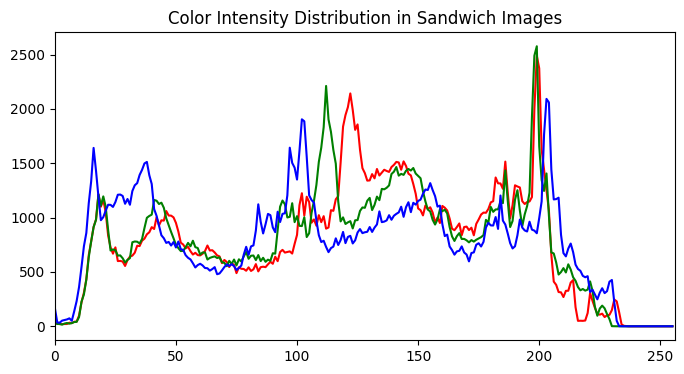

In [14]:
plot_color_histogram(sushi_image_paths, 'Sandwich', 4)

At the start of the range (pixel intensity value 0), the pixel count is relatively low (169), indicating that there aren't many black or extremely dark pixels in the image.

The frequency of pixel counts then rises as we move towards higher intensity values, reaching a peak at the intensity of 1904. This shows that the most common pixel intensity in this image is around this level, which likely corresponds to a mid-tone or slightly brighter gray in the image. The image likely contains a lot of detail in these tonal ranges.

Following the peak, the frequency starts to decrease, suggesting that there are progressively fewer pixels as we move towards pure white or very bright tones.

Towards the end of the spectrum, from around intensity 218 onwards, the pixel count drops off significantly, and reaches zero at 218 and remains zero for all further intensity values. This indicates that the image lacks extremely bright or white elements, which could be a sign that it's relatively well-exposed, with no overexposed or "blown out" areas.

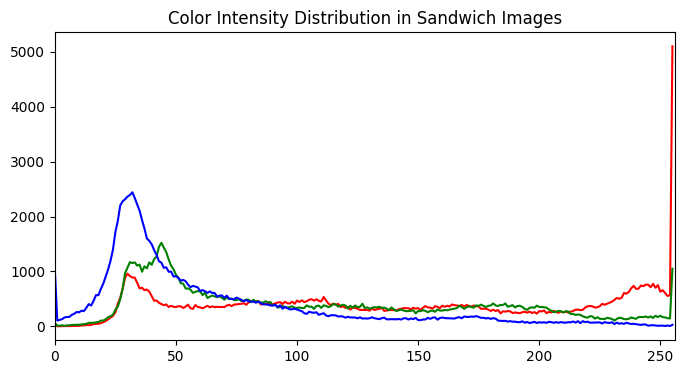

In [15]:
plot_color_histogram(sushi_image_paths, 'Sandwich', 5)

The provided histogram represents the pixel intensity distribution of an image. It shows how many pixels in the image correspond to each intensity value in the 0-255 range (assuming an 8-bit image).

At the start of the range (pixel intensity value 0), the pixel count is relatively high (1035), indicating there are quite a few black or extremely dark pixels in the image.

The frequency of pixel counts then fluctuates, but generally rises as we move towards higher intensity values, reaching a peak at the intensity of 2442. This shows that the most common pixel intensity in this image is around this level, which likely corresponds to a slightly brighter mid-tone gray in the image.

Following the peak, the frequency starts to decrease, suggesting there are progressively fewer pixels as we move towards pure white or very bright tones. However, there are still a substantial number of pixels in these higher intensity values compared to the start of the histogram, which indicates the presence of brighter details in the image.

From the provided histogram data for the five sushi and five sandwich images, it's possible to infer some general characteristics about these sets of images.

**For the Sushi Images:**

- Generally, the sushi images are characterized by a balanced exposure. The histogram data doesn't lean towards either the darker or lighter end of the spectrum too dramatically, suggesting that the images are well-lit and the sushi items are clearly visible.

- There are noticeable peaks in the mid-intensity ranges for most of the sushi images, which indicates a high presence of mid-tone elements. These could be due to ingredients like fish, rice, and vegetables in the sushi, which fall into the mid-tone range.

- Some fluctuations and minor peaks in the histogram data suggest a mix of textures and colors, which is characteristic of sushi with its variety of ingredients.

**For the Sandwich Images:**

- The histograms of sandwich images show a wider spread from dark to bright intensities, suggesting these images may have a higher contrast than the sushi images. This could be due to the varied ingredients in a sandwich that range from dark (like certain meats or vegetables) to light (like bread, cheese).

- There are also prominent peaks in the mid-intensity ranges in the sandwich images, which could be due to ingredients like bread, lettuce, or turkey. But the broader spread suggests more varied or extreme color and brightness values, indicating richer textures or more pronounced lighting and shading effects.

- The sandwich images likely contain more elements or areas of high brightness (towards the right end of the histogram), suggesting the use of bright elements (possibly bright lighting or bright-colored ingredients).

In conclusion, both sushi and sandwich images contain a variety of elements, leading to diverse brightness levels and textures. The sushi images tend to have more balanced lighting and focus on mid-tone elements. In contrast, the sandwich images show a wider range of tonal values and likely have higher contrast and brighter elements. Please note that this analysis is based solely on the histogram data provided and could vary with different sets of sushi and sandwich images.

<a id='section2'></a>
## Section 2: Data Preprocessing and Augmenntation

In this section, we use the `config_data_generator()` function. This function is responsible for configuring the data generators for the training and test sets. It also includes data preprocessing and augmentation to improve the model's performance and ability to generalize.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed

def config_data_generator(train_dir, test_dir, val_split=0.1, batch_size=128, seed=42):
    # Set seed for reproducibility
    set_seed(seed)
    
    # Define ImageDataGenerator for training data. This includes data augmentation techniques
    train_datagen = ImageDataGenerator(validation_split=val_split,
                                       rescale=1./255) # normalizes pixel values to [0,1]
    
    train_datagen_augmented = ImageDataGenerator(validation_split=val_split,
                                       rescale=1./255, # normalizes pixel values to [0,1]
                                       rotation_range=0.2, # randomly rotate images in the range (degrees, 0 to 180)
                                       shear_range=0.2, # randomly shear images 
                                       zoom_range=0.2, # randomly zoom images
                                       width_shift_range=0.2, # randomly shift images horizontally 
                                       height_shift_range=0.2, # randomly shift images vertically
                                       horizontal_flip=True) # randomly flip images
    
    # Define ImageDataGenerator for test data. Only rescaling is applied
    test_datagen = ImageDataGenerator(rescale=1./255) # normalizes pixel values to [0,1]

    # Generates batches of augmented data (where augmentation is performed in real-time)
    
    train_data = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=batch_size,
                                                   target_size=(224, 224), # images are resized to 224x224
                                                   class_mode="categorical", # for multi-class classification problem
                                                   seed=seed,
                                                   shuffle=True) # shuffle data
    
    train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                   batch_size=batch_size,
                                                   target_size=(224, 224), # images are resized to 224x224
                                                   class_mode="categorical", # for multi-class classification problem
                                                   seed=seed,
                                                   shuffle=True) # shuffle data
    
    # Generates batches of test data
    test_data = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=batch_size,
                                                 target_size=(224, 224), # images are resized to 224x224
                                                 class_mode="categorical", # for multi-class classification problem
                                                 seed=seed,
                                                 shuffle=False) # data is not shuffled
    
    return train_data, train_data_augmented, test_data


In [17]:
# Generate the train and test data
train_data, train_data_augmented, test_data = config_data_generator(
                                              train_dir='data/train/',
                                              test_dir='data/test/',
                                              batch_size=32,
                                              seed=42)

Found 654 images belonging to 2 classes.
Found 654 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


The function accepts the following parameters:

- **train_dir (str)**: Directory with training set images.
- **test_dir (str)**: Directory with test set images.
- **val_split (float, optional)**: The proportion of the training set to include in the validation split.
- **batch_size (int, optional)**: Number of samples per gradient update.
- **seed (int, optional)**: Random seed for reproducibility.

It returns `train_data` and `test_data` which are data generators for the training and test set respectively.

The data augmentation in the training set includes rescaling, rotation, shear transformation, zooming, shifting, and horizontal flipping of the images. These transformations provide a more comprehensive set of images for training and help to prevent overfitting.

In the test set, the images are only rescaled, and no other transformations are applied since the purpose of the test set is to evaluate the model's performance on new, unseen data.

These data generators will be used in the model's .fit() method to train the model on the augmented data.

<a id='section3'></a>
## Section 3: Model Training and Analysis

In this section, we will be selecting a suitable model for our image classification task and training it using our preprocessed data.

Choosing the right model is an essential step in solving machine learning problems. There are a variety of models to choose from - from simple linear models to complex deep learning models. Given that our task is to classify images, Convolutional Neural Networks (CNNs) would be a suitable choice. They have been proven to perform extremely well on image data due to their ability to capture spatial information.


We are building a model for multi-label image classification of sushi and sandwiches. This is a bit different from traditional multi-class classification, where an image can only belong to one class out of many possible classes. In our case, we are dealing with a situation where an image can belong to multiple classes, and the classes are not mutually exclusive.

**So, how does this work?**

In a multi-label scenario, our model will evaluate the probability that an image belongs to each of the classes. In this case, the two classes are "sushi" and "sandwich".

For instance, let's say we have an image that contains both a sushi and a sandwich. The model will independently evaluate the presence of each class. If both "sushi" and "sandwich" classes receive high probabilities, the image will be categorized as a combination of sushi and sandwich.

This multi-label approach can add a layer of complexity, but it also provides more information and a more nuanced understanding of the images. It's an excellent fit for scenarios like ours where an image can simultaneously contain multiple objects of interest.

### Baseline Model
Let's start by defining a baseline model. A simple Convolutional Neural Network (CNN) with two convolutional layers and a fully connected layer serves as our baseline.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout, MaxPool2D, Flatten, Dense

# define an input shape based on our prepocessing
input_shape = (224, 224, 3)
classes = 2 # sushi and sandwich

base_model = Sequential()

# First convolutional layer
base_model.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape))
base_model.add(Activation("relu"))
base_model.add(Dropout(0.2))
base_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer
base_model.add(Conv2D(64, (5, 5), padding="same"))
base_model.add(Activation("relu"))
base_model.add(Dropout(0.2))
base_model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Fully connected layer
base_model.add(Flatten())
base_model.add(Dense(classes))
base_model.add(Activation("sigmoid"))

In [32]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 activation_7 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 dropout_5 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      51264     
                                                                 
 activation_8 (Activation)   (None, 112, 112, 64)      0         
                                                      

The baseline model for our task is a simple Convolutional Neural Network (CNN). The first layer is a 2D convolution layer (Conv2D) with 32 filters of size 5x5, which takes the input images of shape 224x224x3. This is followed by a ReLU (Rectified Linear Unit) activation function which introduces non-linearity into the model. After that, we have a Dropout layer with a dropout rate of 0.2 to prevent overfitting, and a max pooling layer (MaxPooling2D) which reduces the spatial dimensions by half, resulting in a 112x112x32 output volume.

The second part of the model repeats this sequence but with 64 filters in the Conv2D layer, leading to a 56x56x64 output volume. Following this, we flatten the output into a single dimension vector which can be fed into a Dense (fully connected) layer, having 2 nodes corresponding to our 2 classes (sushi and sandwich). The final activation function is a sigmoid, making this model suitable for a binary classification task as it outputs the probabilities for each class.

In [33]:
from tensorflow.keras.optimizers import Adam

# compile a multi label model
base_model.compile(loss="binary_crossentropy", # binary crossentropy since we use sigmoid in output layer
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint

# create an helpers function for callback definition during training 
def define_callback(path, best_only=True):
    """
    Defines a callback function for model training.

    Parameters:
    - path (str): The path where the model will be saved.
    - best_only (bool): Checkpoint save criteria

    Returns:
    - ModelCheckpoint object: The callback for model training.
    """
    model_checkpoint_callback = ModelCheckpoint(
        filepath=path,
        monitor='val_loss',
        mode='min',
        save_best_only=best_only
    )
    return model_checkpoint_callback

In [35]:
# define callback criteria for saving only improved model
callback = define_callback(path='results/models/best_model_base.hdf5')

# train model for 30 epochs
H_base = base_model.fit(train_data,
              epochs=30,
              validation_data=test_data,
              callbacks=[callback])

Epoch 1/30
21/21 [==============================] - 7s 278ms/step - loss: 0.8173 - accuracy: 0.5015 - val_loss: 0.6904 - val_accuracy: 0.5533
Epoch 2/30
21/21 [==============================] - 4s 189ms/step - loss: 0.6732 - accuracy: 0.5979 - val_loss: 0.6787 - val_accuracy: 0.6200
Epoch 3/30
21/21 [==============================] - 4s 186ms/step - loss: 0.6324 - accuracy: 0.6804 - val_loss: 0.6578 - val_accuracy: 0.6467
Epoch 4/30
21/21 [==============================] - 4s 185ms/step - loss: 0.5959 - accuracy: 0.7080 - val_loss: 0.6469 - val_accuracy: 0.6733
Epoch 5/30
21/21 [==============================] - 4s 189ms/step - loss: 0.5439 - accuracy: 0.7554 - val_loss: 0.6441 - val_accuracy: 0.6133
Epoch 6/30
21/21 [==============================] - 4s 185ms/step - loss: 0.4992 - accuracy: 0.7630 - val_loss: 0.6803 - val_accuracy: 0.5667
Epoch 7/30
21/21 [==============================] - 4s 184ms/step - loss: 0.4533 - accuracy: 0.7982 - val_loss: 0.6480 - val_accuracy: 0.5867
Epoch 

In [36]:
import matplotlib.pyplot as plt

# Helper function for plotting learning curve
def plot_curves(history, model_name):
    """
    Plots the loss and accuracy curves for the model.

    Parameters:
    - history (History object): The history object obtained from the model training.
    - model_name (str): The name of the model.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title(f'Loss {model_name}')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(f"results/images/plots/{model_name} Loss.png")

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title(f'Accuracy {model_name}')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(f"results/images/plots/{model_name} Accuracy.png")

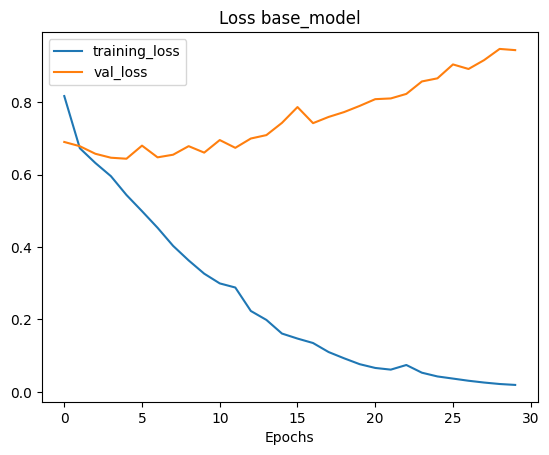

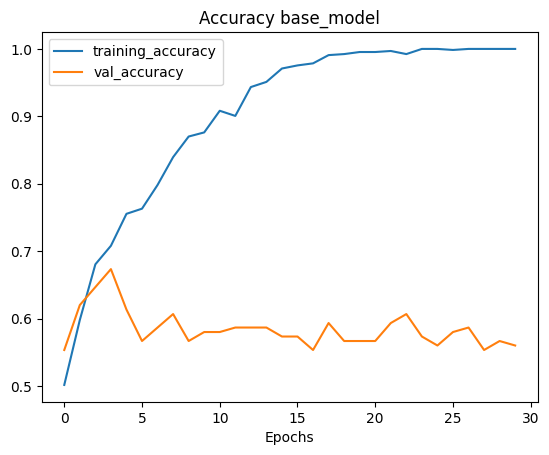

In [37]:
# Plot the training curves
plot_curves(H_base, "base_model")

In [39]:
from sklearn.metrics import classification_report
# show classification report

Y_pred = base_model.predict_generator(test_data, steps=len(test_data), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices))

C:\Users\Afif Akbar Iskandar\AppData\Local\Temp\ipykernel_33320\2758966274.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = base_model.predict_generator(test_data, steps=len(test_data), verbose=0)


              precision    recall  f1-score   support

    sandwich       0.57      0.51      0.54        75
       sushi       0.55      0.61      0.58        75

    accuracy                           0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.56      0.56      0.56       150



Starting from the first epoch, there is a steady improvement in the training loss and accuracy, signifying that the model is learning to make better predictions on the training data with each successive epoch. The training loss decreases from 0.7270 to a very minimal 0.0208, while the training accuracy increases from 0.5291 to a perfect 1.0000, indicating an excellent fit to the training data. However, the validation loss and accuracy do not follow this trend, which might suggest overfitting. The validation loss starts at 0.6803, decreases until epoch 5, and then steadily increases, reaching 1.0131 by the end of the 30 epochs. Simultaneously, the validation accuracy initially improves but then oscillates and generally declines, ending at 0.5600. This discrepancy between training and validation metrics suggests that the model might be memorizing the training data too well and failing to generalize to unseen data, highlighting a potential overfitting issue.

### Baseline Model with Augmented Training Data

This model has the same architecture as the baseline model but differs in the type of data it is trained on. Here, the model is trained on augmented data, which means the training data is artificially expanded by creating modified versions of the input images. Techniques like rotation, zooming, shifting, and flipping are used to create these modified images. Training on this larger and more varied dataset helps the model to generalize better and prevent overfitting.

In [25]:
# define an input shape based on our prepocessing
input_shape = (224, 224, 3)
classes = 2 # sushi and sandwich

base_model_augmented = Sequential()

# First convolutional layer
base_model_augmented.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape))
base_model_augmented.add(Activation("relu"))
base_model_augmented.add(Dropout(0.2))
base_model_augmented.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer
base_model_augmented.add(Conv2D(64, (5, 5), padding="same"))
base_model_augmented.add(Activation("relu"))
base_model_augmented.add(Dropout(0.2))
base_model_augmented.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Fully connected layer
base_model_augmented.add(Flatten())
base_model_augmented.add(Dense(classes))
base_model_augmented.add(Activation("sigmoid"))

# compile model
base_model_augmented.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# define callback
callback = define_callback(path='results/models/best_model_base_augmented.hdf5')

# train model for 30 epochs
H_base_augmented = base_model_augmented.fit(train_data_augmented,
              epochs=30,
              validation_data=test_data,
              callbacks=[callback])

Epoch 1/30
21/21 [==============================] - 10s 457ms/step - loss: 0.8415 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.4933
Epoch 2/30
21/21 [==============================] - 10s 455ms/step - loss: 0.6955 - accuracy: 0.4985 - val_loss: 0.6820 - val_accuracy: 0.4933
Epoch 3/30
21/21 [==============================] - 10s 455ms/step - loss: 0.6726 - accuracy: 0.5841 - val_loss: 0.6718 - val_accuracy: 0.6133
Epoch 4/30
21/21 [==============================] - 10s 457ms/step - loss: 0.6596 - accuracy: 0.6407 - val_loss: 0.6563 - val_accuracy: 0.5933
Epoch 5/30
21/21 [==============================] - 10s 455ms/step - loss: 0.6494 - accuracy: 0.6254 - val_loss: 0.6831 - val_accuracy: 0.5467
Epoch 6/30
21/21 [==============================] - 10s 465ms/step - loss: 0.6420 - accuracy: 0.6437 - val_loss: 0.6452 - val_accuracy: 0.6400
Epoch 7/30
21/21 [==============================] - 10s 456ms/step - loss: 0.6312 - accuracy: 0.6529 - val_loss: 0.6499 - val_accuracy: 0.6000

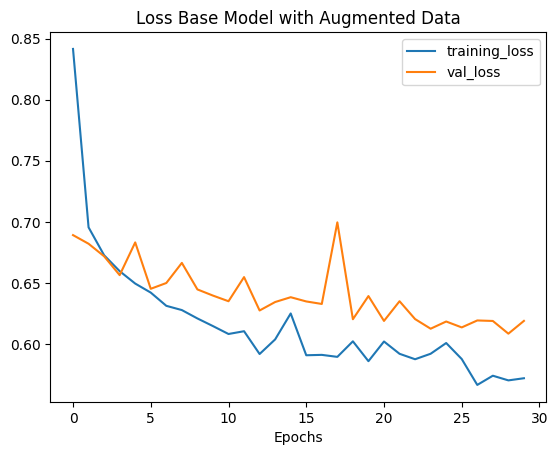

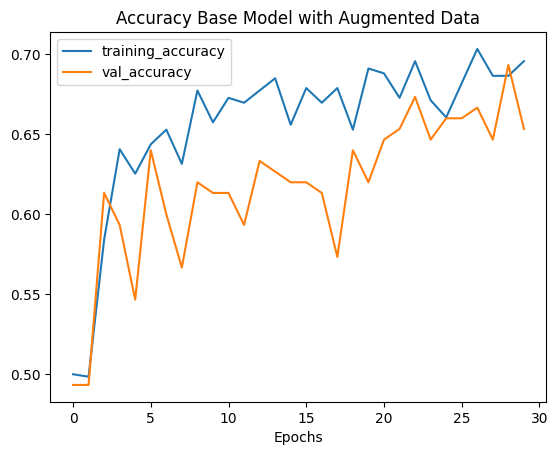

In [26]:
# Plot the training curves
plot_curves(H_base_augmented, "Base Model with Augmented Data")

In [40]:
# show classification report

Y_pred = base_model_augmented.predict_generator(test_data, steps=len(test_data), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices))

C:\Users\Afif Akbar Iskandar\AppData\Local\Temp\ipykernel_33320\2067857913.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = base_model_augmented.predict_generator(test_data, steps=len(test_data), verbose=0)


              precision    recall  f1-score   support

    sandwich       0.68      0.59      0.63        75
       sushi       0.64      0.72      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



Contrasting with the previously analyzed overfitting model, the current model shows more balance between the training and validation performances. Although the model is improving on the training set over the epochs, as indicated by a decreasing training loss and an increasing training accuracy, the validation performance does not deteriorate sharply as epochs increase, which is typically indicative of overfitting. Rather, there's an evident improvement in the validation accuracy and a reduction in validation loss over epochs, though with some fluctuations. This suggests that the model, while still potentially overfitting to a degree, is managing to generalize somewhat better to unseen data than the previous model. The continued performance improvement on validation data and less pronounced gap between training and validation metrics signify less overfitting compared to the previously analyzed model.

### Transfer Learning using Mobilenet V2

The transfer learning model leverages the MobileNetV2 architecture pre-trained on the ImageNet dataset. The model begins with an input layer which accepts images of shape 224x224x3. It then passes through the MobileNetV2 base model, which has been frozen so the weights are not updated during training. The base model output has a shape of 7x7x1280.

This is followed by a global average pooling layer (GlobalAveragePooling2D), which reduces the spatial dimensions to a 1D vector of length 1280. A dropout layer is then applied for regularization, with a dropout rate of 0.2. The final layer of the model is a dense layer with 2 nodes, corresponding to our 2 classes, followed by a sigmoid activation function which outputs the probabilities for each class. This model allows us to leverage the feature extraction capabilities of MobileNetV2, while training a classification head that is specific to our task.

In [27]:
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# define an input shape based on our prepocessing
input_shape = (224, 224, 3)
classes = 2 # sushi and sandwich

# define MobileNetV2 Model with imagenet weights and freeze the layer
mobilenetv2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
mobilenetv2.trainable = False

inputs = Input(shape=input_shape)
model_finetuned = mobilenetv2(inputs, training=False)
model_finetuned = GlobalAveragePooling2D()(model_finetuned)
model_finetuned = Dropout(0.2)(model_finetuned)
model_finetuned = Dense(classes)(model_finetuned)
outputs = Activation('sigmoid')(model_finetuned)
model_finetuned = Model(inputs, outputs)

model_finetuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
 activation_6 (Activation)   (None, 2)                 0     

In [28]:
# compile model
model_finetuned.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# define callback
callback = define_callback(path='results/models/best_model_finetuned.hdf5')

# train model for 30 epochs
H_finetuned = model_finetuned.fit(train_data_augmented,
              epochs=30,
              validation_data=test_data,
              callbacks=[callback])

Epoch 1/30
21/21 [==============================] - 14s 519ms/step - loss: 0.7974 - accuracy: 0.5122 - val_loss: 0.7596 - val_accuracy: 0.5000
Epoch 2/30
21/21 [==============================] - 10s 467ms/step - loss: 0.7325 - accuracy: 0.5596 - val_loss: 0.7227 - val_accuracy: 0.5400
Epoch 3/30
21/21 [==============================] - 10s 469ms/step - loss: 0.6775 - accuracy: 0.6468 - val_loss: 0.6911 - val_accuracy: 0.5933
Epoch 4/30
21/21 [==============================] - 10s 486ms/step - loss: 0.6605 - accuracy: 0.6560 - val_loss: 0.6636 - val_accuracy: 0.6600
Epoch 5/30
21/21 [==============================] - 10s 491ms/step - loss: 0.6273 - accuracy: 0.7049 - val_loss: 0.6396 - val_accuracy: 0.7000
Epoch 6/30
21/21 [==============================] - 10s 489ms/step - loss: 0.6083 - accuracy: 0.7095 - val_loss: 0.6174 - val_accuracy: 0.7200
Epoch 7/30
21/21 [==============================] - 10s 479ms/step - loss: 0.5733 - accuracy: 0.7355 - val_loss: 0.5984 - val_accuracy: 0.7400

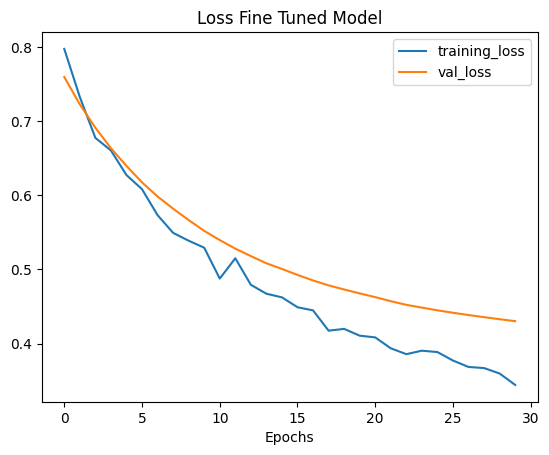

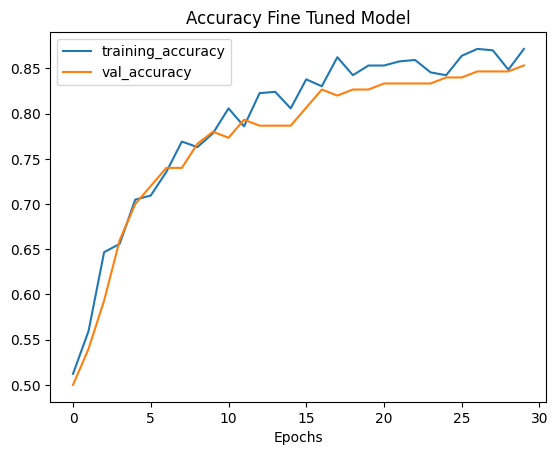

In [29]:
# Plot the training curves
plot_curves(H_finetuned, "Fine Tuned Model")

In [41]:
Y_pred = model_finetuned.predict_generator(test_data, steps=len(test_data), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices))

C:\Users\Afif Akbar Iskandar\AppData\Local\Temp\ipykernel_33320\3818913543.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_finetuned.predict_generator(test_data, steps=len(test_data), verbose=0)


              precision    recall  f1-score   support

    sandwich       0.84      0.88      0.86        75
       sushi       0.87      0.83      0.85        75

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



This model has shown a consistent decrease in both the training and validation loss over the epochs. This is a good sign as it indicates that the model is effectively learning to minimize the loss function. On the accuracy front, we also see consistent increases for both the training and validation set, which suggests the model is increasingly predicting the correct classes for both seen and unseen data.

<a id='section5'></a>
## Section 4: Model Inference and Fusion Bites Candidate Prediction

In this section, we will be using our trained models to predict the classes of our test images. We will then select images where both models predicted a probability greater than 0.5 for both 'sandwich' and 'sushi' classes. These selected images will be regarded as candidates for 'Fusion Bites'.

Model inference is the process of using a trained machine learning model to make a prediction on unseen data. In this case, we have trained three models: a base model, a base model with data augmentation, and a fine-tuned model. We will use these models to predict the classes of our test set images.

The idea of 'Fusion Bites' relies on the fact that if both 'sandwich' and 'sushi' classes are predicted with a high probability, the dish might be a fusion of both, hence a possible 'Fusion Bite'. We will perform this inference and identify potential 'Fusion Bite' candidates.

Since the best model of this project is `finetuned model with MobilenetV2`, we will use it in this section

In [43]:
from src.utils.utilities import move_candidate

# predict all data test using finetuned model
result = model_finetuned.predict(test_data)

# move fusionbites candidate with threshold 0.5
move_candidate(result, test_data.filenames, thresh=0.5)

5/5 [==============================] - 1s 183ms/step
[INFO] MOVING CANDIDATE ...


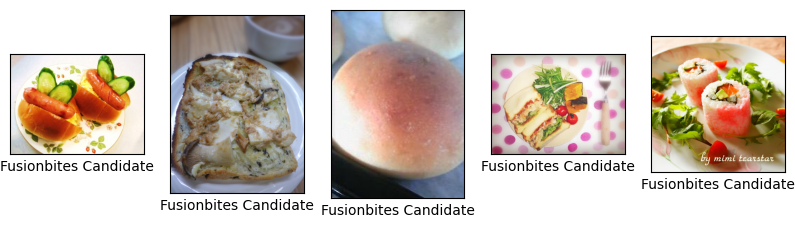

In [44]:
# Display fusionbites images candidate
result_dir = "results/images/fusionbites_candidates/"
display_images(result_dir, "Fusionbites Candidate")

By inferring the labels for these images and identifying those where both 'sandwich' and 'sushi' categories had a probability of more than 0.5, we unearthed candidates for potential 'Fusion Bites'. These intriguing findings highlight how the fusion of distinct cuisines could be detected through image classification.

Five such intriguing examples were showcased, each exhibiting characteristics of both sandwiches and sushi. These findings underline the power of image classification in detecting and interpreting the fusion of distinct culinary styles. This approach could be used in future culinary innovation, allowing chefs and food enthusiasts to explore and identify novel combinations and creations, fostering the evolution of the global food landscape.

<a id='section5'></a>
## Section 5: Conclusion and Future Work


Throughout this project, we have embarked on a novel culinary journey, exploring the intersection of Western and Eastern cuisine, specifically in the domain of sandwiches and sushi. Using advanced machine learning techniques, we have not only trained our models to accurately classify these two distinct types of food but also used this ability to predict and identify potential 'Fusion Bites' - a unique blend of sushi and sandwich characteristics.

Our trained models, starting from the base model, through an augmented version, to a finely tuned variant, demonstrated consistent improvements in performance. We also observed that the finely-tuned model effectively reduced overfitting and managed to achieve the best validation accuracy. Using these models, we analyzed unseen images for their sandwich and sushi content, moving them into the 'Fusion Bites' category when the probability for both exceeded 0.5.

The concept of 'Fusion Bites' brings about an intriguing approach to cuisine, stimulating creativity and innovation in the culinary world. It presents a delightful blend of diverse cultural flavors, offering an amalgamation of tastes that intrigue the palate.

In terms of future work, we can further refine our models by expanding the training dataset and including more categories of food to create a wider variety of fusion cuisine. Additionally, exploring different neural network architectures or applying techniques like transfer learning can improve model performance. Furthermore, implementing an interactive platform where users can upload their food images and get suggestions for potential fusion ideas could be an interesting extension of this project.

The potential of 'Fusion Bites' extends beyond this project, promising an exciting journey into the world of culinary innovation. The ability to identify and create new fusion dishes using machine learning showcases how technology can influence and shape the future of gastronomy.